In [26]:
import scipy.io as sio
from matplotlib import pyplot as plt 
%matplotlib inline

from mne.viz import plot_compare_evokeds

import numpy as np 

import os 
from andante_pd_ft2mne import import2mne  

#matfile = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/probands/data_cleaned_newfilt_subj_01k101k1.mat'


Test on all subjects 
--

In [30]:
#datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_newfilt/'
#datadir = '/Users/nicolasfarrugia/Documents/recherche/PD/PDNewAnalysis/data/eeg_task/analysis/data_ica_cleaned/'

datadir = '/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/'
resultdir = '/home/nfarrugi/datasets/mpi_pd_cueing/results_fkbest40_average4/'

import os 

allcontrols = os.listdir(os.path.join(datadir,'probands'))
allpatients = os.listdir(os.path.join(datadir,'patients'))

In [17]:
from utils import *

In [31]:
from andante_pd_ft2mne import import2mne  
from mne import Epochs,EpochsArray
from mne.channels import read_montage

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.decomposition import PCA

import mne
from mne.datasets import sample
from mne.decoding import GeneralizingEstimator
from mne.decoding import CSP
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold


def timegen_process_2x2(matfile,ncv=5,metric='accuracy',tmin=-0.05,tmax=0.15,pca=None,kbest = None,
                        condnames=['iso_std','iso_dev'],condnames_2=['rnd_std','rnd_dev'],average=0):
    
    
    
    subjid = matfile[-8:-4]
    print("Subject : %s " % subjid)
    
    ## Open file 
    mneEpochs = import2mne(matfile,average=average)
    mneEpochs_short = mneEpochs.crop(tmin=tmin,tmax=tmax)
    
    
    montage = read_montage('standard_1020')

    mneEpochs_short.set_montage(montage)

    ## Perform Supervised Learning using Temporal Generalization 
    
    epochs = mneEpochs_short[condnames]
    epochs_cond2 = mneEpochs_short[condnames_2]
    
    if pca is not None:
        if kbest is not None:
            raise('Cannot use both kbest and PCA!')
        clf = make_pipeline(PCA(n_components=pca),StandardScaler(),LogisticRegression())

    elif kbest is not None:
        clf = make_pipeline(SelectKBest(k=kbest),StandardScaler(),LogisticRegression())
    else:
        clf = make_pipeline(StandardScaler(),LogisticRegression())
        
    time_gen = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    time_gen_cond2 = GeneralizingEstimator(clf, scoring=metric, n_jobs=-2)

    
    # Get the labels
    labels = epochs.events[:, -1]
    labels_2 = epochs_cond2.events[:, -1]

    # Cross validator
    cv = StratifiedKFold(n_splits=ncv, shuffle=True, random_state=42)

    
    ### We will calculate a 2x2 matrix
    ### First, let's cal
    
    
    scores1_1 = []
    scores1_2 = []
    scores2_1 = []
    scores2_2 = []
    
    proba1_1 = []
    proba1_2 = []
    proba2_1 = []
    proba2_2 = []
    
    U1_1 = []
    U1_2 = []
    U2_1 = []
    U2_2 = []
    
    allpval1_1=[]
    allpval1_2=[]
    allpval2_1=[]
    allpval2_2=[]

    
    for train, test in cv.split(epochs, labels):
        for train2, test2 in cv.split(epochs_cond2,labels_2):

            # Train classifier1 on train data of condition 1 
            time_gen.fit(X=epochs[train].get_data(), y=labels[train])

            # Train classifier2 on train data of condition 2 
            time_gen_cond2.fit(X=epochs_cond2[train2].get_data(), y=labels_2[train2])
            
            # Test Classifier1 on test data of condition 1
            scores1_1.append(time_gen.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba1_1.append(proba_av)
            U1_1.append(U)
            allpval1_1.append(allpval)
            
            
            # Test Classifier1 on test data of condition 2
            scores1_2.append(time_gen.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba1_2.append(proba_av)
            U1_2.append(U)
            allpval1_2.append(allpval)
            
            # Test Classifier2 on test data of condition 1
            scores2_1.append(time_gen_cond2.score(X=epochs[test].get_data(),y=labels[test]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs[test].get_data()),y=labels[test])
            proba2_1.append(proba_av)
            U2_1.append(U)
            allpval2_1.append(allpval)
            
            # Test Classifier2 on test data of condition 2
            scores2_2.append(time_gen_cond2.score(X=epochs_cond2[test2].get_data(),y=labels_2[test2]))
            
            U,allpval,proba_av = mann_witt_matrix(time_gen_cond2.predict_proba(X=epochs_cond2[test2].get_data()),y=labels_2[test2])
            proba2_2.append(proba_av)
            U2_2.append(U)
            allpval2_2.append(allpval)

        
    scores1_1 = np.stack(scores1_1)
    
    scores1_2 = np.stack(scores1_2)
    
    scores2_1 = np.stack(scores2_1)
    
    scores2_2 = np.stack(scores2_2)
    
    proba1_1 = np.stack(proba1_1)
    
    proba1_2 = np.stack(proba1_2)
    
    proba2_1 = np.stack(proba2_1)
    
    proba2_2 = np.stack(proba2_2)
    
    U1_1 = np.stack(U1_1)
    U1_2 = np.stack(U1_2)
    U2_1 = np.stack(U2_1)
    U2_2 = np.stack(U2_2)
    
    allpval1_1 = np.stack(allpval1_1)
    allpval1_2 = np.stack(allpval1_2)
    allpval2_1 = np.stack(allpval2_1)
    allpval2_2 = np.stack(allpval2_2)
    
    scores = np.stack([scores1_1,scores1_2,scores2_1,scores2_2])
    allU = np.stack([U1_1,U1_2,U2_1,U2_2])
    allpvals = np.stack([allpval1_1,allpval1_2,allpval2_1,allpval2_2])
    allproba = np.stack([proba1_1,proba1_2,proba2_1,proba2_2])
     
    return scores,allU,allpvals,allproba,epochs.times[[0, -1, 0, -1]]

Formal structure

In [19]:
temporal = ['iso_std','rnd_std']
formal_iso = ['iso_std','iso_dev']
formal_rnd = ['rnd_std','rnd_dev']

tmin = -0.05
tmax = 0.52
ncv  = 2

#tmin = 0.25
#tmax = 0.40
#ncv  = 2

allscores_formal = []
allproba_formal = []

allU_formal = []
allpval_formal= []

listofsubj = [allcontrols,allpatients]



In [13]:
curfile = os.path.join(datadir,'probands',listofsubj[0][0])

print(curfile)

subjid = curfile[-8:-4]

allscores,allU,allpvals,allproba,timepoints= timegen_process_2x2(curfile,metric='roc_auc',
                                                                 tmin=tmin,tmax=tmax,
                                                                 ncv=ncv,condnames=formal_iso,
                                                                 condnames_2=formal_rnd,
                                                                pca=0.8,kbest=25)

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_10k1.mat
Subject : 10k1 
671 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


TypeError: exceptions must derive from BaseException

/home/nfarrugi/datasets/mpi_pd_cueing/data_ica_cleaned/probands/data_cleaned_subj_10k1.mat


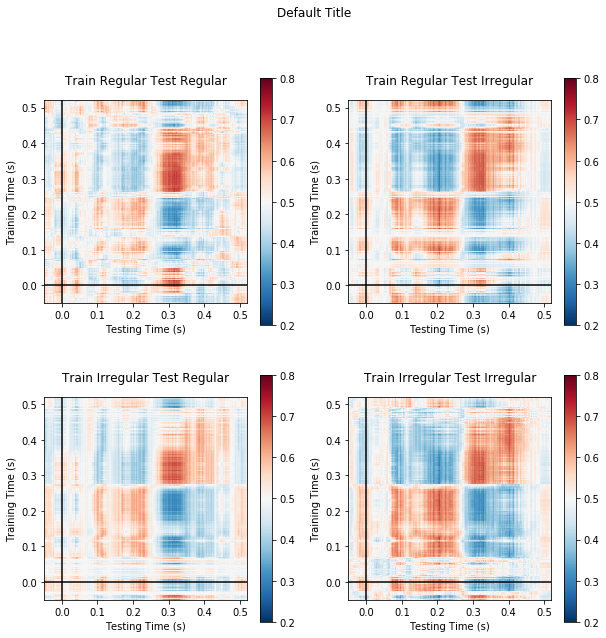

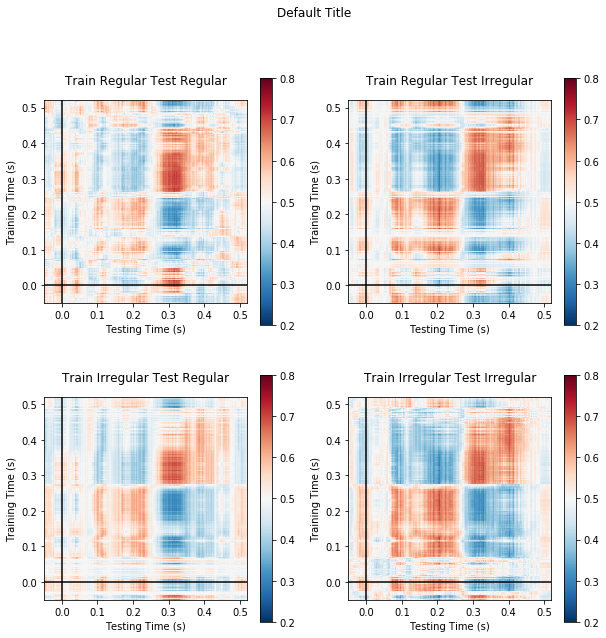

In [8]:
print(curfile)
plot_ROC_allcond(allscores,timepoints,figtitle='Default Title')

In [32]:
os.mkdir(resultdir)

On all subjects 

In [33]:
savenpz = True
for kk,group in enumerate(['probands','patients']):

    curlist = listofsubj[kk]
    
    for matfile in curlist:
        curfile = os.path.join(datadir,group,matfile)
        subjid = curfile[-8:-4]

        allscores,allU,allpvals,allproba,timepoints= timegen_process_2x2(curfile,metric='roc_auc',tmin=tmin,tmax=tmax,
                                                 ncv=ncv,condnames=formal_iso,condnames_2=formal_rnd,kbest=40,average=4)
        
       

        if savenpz:
            np.savez_compressed(os.path.join(resultdir,"180802_%s_formal_conditionwise.npz" % subjid),
                                scores=allscores,
                                proba = allproba,
                                U = allU,
                                pval=allpvals)

Subject : 10k1 
Averaging 4 consecutive trials for each condition
(258, 61, 425) (81, 61, 425) (256, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(64, 61, 425) (20, 61, 425) (64, 61, 425) (19, 61, 425)
---
167 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


Subject : 03k1 
Averaging 4 consecutive trials for each condition
(243, 61, 425) (66, 61, 425) (233, 61, 425) (79, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (16, 61, 425) (58, 61, 425) (19, 61, 425)
---
153 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 12k1 
Averaging 4 consecutive trials for each condition
(264, 61, 425) (75, 61, 425) (263, 61, 425) (83, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (65, 61, 425) (20, 61, 425)
---
169 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 08k1 
Averaging 4 consecutive trials for each condition
(224, 61, 425) (65, 61, 425) (221, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (16, 61, 425) (55, 61, 425) (19, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 18k1 
Averaging 4 consecutive trials for each condition
(215, 61, 425) (61, 61, 425) (234, 61, 425) (74, 61, 425)
Result of averaging 4 consecutive trials for each condition
(53, 61, 425) (15, 61, 425) (58, 61, 425) (18, 61, 425)
---
144 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished


Subject : 13k1 
Averaging 4 consecutive trials for each condition
(242, 61, 425) (79, 61, 425) (236, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (19, 61, 425) (59, 61, 425) (19, 61, 425)
---
157 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


Subject : 14k1 
Averaging 4 consecutive trials for each condition
(240, 61, 425) (76, 61, 425) (244, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (19, 61, 425) (61, 61, 425) (19, 61, 425)
---
159 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished


Subject : 04k1 
Averaging 4 consecutive trials for each condition
(263, 61, 425) (77, 61, 425) (249, 61, 425) (81, 61, 425)
Result of averaging 4 consecutive trials for each condition
(65, 61, 425) (19, 61, 425) (62, 61, 425) (20, 61, 425)
---
166 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 02k1 
Averaging 4 consecutive trials for each condition
(235, 61, 425) (72, 61, 425) (233, 61, 425) (72, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (58, 61, 425) (18, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 06k1 
Averaging 4 consecutive trials for each condition
(192, 61, 425) (58, 61, 425) (241, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(48, 61, 425) (14, 61, 425) (60, 61, 425) (17, 61, 425)
---
139 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished


Subject : 09k1 
Averaging 4 consecutive trials for each condition
(213, 61, 425) (66, 61, 425) (238, 61, 425) (57, 61, 425)
Result of averaging 4 consecutive trials for each condition
(53, 61, 425) (16, 61, 425) (59, 61, 425) (14, 61, 425)
---
142 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 16k1 
Averaging 4 consecutive trials for each condition
(247, 61, 425) (78, 61, 425) (245, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(61, 61, 425) (19, 61, 425) (61, 61, 425) (19, 61, 425)
---
160 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    4.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 19k1 
Averaging 4 consecutive trials for each condition
(259, 61, 425) (73, 61, 425) (253, 61, 425) (78, 61, 425)
Result of averaging 4 consecutive trials for each condition
(64, 61, 425) (18, 61, 425) (63, 61, 425) (19, 61, 425)
---
164 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 01k1 
Averaging 4 consecutive trials for each condition
(252, 61, 425) (71, 61, 425) (260, 61, 425) (74, 61, 425)
Result of averaging 4 consecutive trials for each condition
(63, 61, 425) (17, 61, 425) (65, 61, 425) (18, 61, 425)
---
163 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   25.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 17k1 
Averaging 4 consecutive trials for each condition
(267, 61, 425) (72, 61, 425) (226, 61, 425) (67, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (56, 61, 425) (16, 61, 425)
---
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 05k1 
Averaging 4 consecutive trials for each condition
(225, 61, 425) (70, 61, 425) (245, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (17, 61, 425) (61, 61, 425) (18, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 20k1 
Averaging 4 consecutive trials for each condition
(235, 61, 425) (74, 61, 425) (258, 61, 425) (80, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (64, 61, 425) (20, 61, 425)
---
160 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished


Subject : 11k1 
Averaging 4 consecutive trials for each condition
(265, 61, 425) (74, 61, 425) (259, 61, 425) (81, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (64, 61, 425) (20, 61, 425)
---
168 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished


Subject : 15k1 
Averaging 4 consecutive trials for each condition
(176, 61, 425) (61, 61, 425) (213, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(44, 61, 425) (15, 61, 425) (53, 61, 425) (18, 61, 425)
---
130 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 07k1 
Averaging 4 consecutive trials for each condition
(235, 61, 425) (76, 61, 425) (246, 61, 425) (74, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (19, 61, 425) (61, 61, 425) (18, 61, 425)
---
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 11c1 
Averaging 4 consecutive trials for each condition
(221, 61, 425) (81, 61, 425) (241, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(55, 61, 425) (20, 61, 425) (60, 61, 425) (19, 61, 425)
---
154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 03m1 
Averaging 4 consecutive trials for each condition
(249, 61, 425) (84, 61, 425) (249, 61, 425) (72, 61, 425)
Result of averaging 4 consecutive trials for each condition
(62, 61, 425) (21, 61, 425) (62, 61, 425) (18, 61, 425)
---
163 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   23.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished


Subject : 10c1 
Averaging 4 consecutive trials for each condition
(245, 61, 425) (81, 61, 425) (222, 61, 425) (79, 61, 425)
Result of averaging 4 consecutive trials for each condition
(61, 61, 425) (20, 61, 425) (55, 61, 425) (19, 61, 425)
---
155 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished


Subject : 05c2 
Averaging 4 consecutive trials for each condition
(232, 61, 425) (71, 61, 425) (219, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (17, 61, 425) (54, 61, 425) (19, 61, 425)
---
148 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   22.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 07c2 
Averaging 4 consecutive trials for each condition
(241, 61, 425) (71, 61, 425) (239, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (17, 61, 425) (59, 61, 425) (17, 61, 425)
---
153 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished


Subject : 12c2 
Averaging 4 consecutive trials for each condition
(227, 61, 425) (77, 61, 425) (205, 61, 425) (74, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (19, 61, 425) (51, 61, 425) (18, 61, 425)
---
144 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 17c2 
Averaging 4 consecutive trials for each condition
(248, 61, 425) (69, 61, 425) (245, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(62, 61, 425) (17, 61, 425) (61, 61, 425) (19, 61, 425)
---
159 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 01c2 
Averaging 4 consecutive trials for each condition
(243, 61, 425) (83, 61, 425) (237, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (20, 61, 425) (59, 61, 425) (19, 61, 425)
---
158 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 08c3 
Averaging 4 consecutive trials for each condition
(238, 61, 425) (75, 61, 425) (229, 61, 425) (81, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (18, 61, 425) (57, 61, 425) (20, 61, 425)
---
154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 11c2 
Averaging 4 consecutive trials for each condition
(233, 61, 425) (72, 61, 425) (231, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (57, 61, 425) (18, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s finished


Subject : 04c1 
Averaging 4 consecutive trials for each condition
(264, 61, 425) (78, 61, 425) (267, 61, 425) (82, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (19, 61, 425) (66, 61, 425) (20, 61, 425)
---
171 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s finished


Subject : 15c1 
Averaging 4 consecutive trials for each condition
(226, 61, 425) (73, 61, 425) (230, 61, 425) (60, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (18, 61, 425) (57, 61, 425) (15, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished


Subject : 10c2 
Averaging 4 consecutive trials for each condition
(254, 61, 425) (74, 61, 425) (248, 61, 425) (69, 61, 425)
Result of averaging 4 consecutive trials for each condition
(63, 61, 425) (18, 61, 425) (62, 61, 425) (17, 61, 425)
---
160 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 03c3 
Averaging 4 consecutive trials for each condition
(251, 61, 425) (71, 61, 425) (255, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(62, 61, 425) (17, 61, 425) (63, 61, 425) (18, 61, 425)
---
160 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 03c1 
Averaging 4 consecutive trials for each condition
(253, 61, 425) (81, 61, 425) (234, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(63, 61, 425) (20, 61, 425) (58, 61, 425) (17, 61, 425)
---
158 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 05c1 
Averaging 4 consecutive trials for each condition
(245, 61, 425) (78, 61, 425) (254, 61, 425) (82, 61, 425)
Result of averaging 4 consecutive trials for each condition
(61, 61, 425) (19, 61, 425) (63, 61, 425) (20, 61, 425)
---
163 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s finished


Subject : 08c1 
Averaging 4 consecutive trials for each condition
(222, 61, 425) (64, 61, 425) (244, 61, 425) (79, 61, 425)
Result of averaging 4 consecutive trials for each condition
(55, 61, 425) (16, 61, 425) (61, 61, 425) (19, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished


Subject : 13c3 
Averaging 4 consecutive trials for each condition
(236, 61, 425) (74, 61, 425) (224, 61, 425) (68, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (18, 61, 425) (56, 61, 425) (17, 61, 425)
---
150 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 13c1 
Averaging 4 consecutive trials for each condition
(260, 61, 425) (76, 61, 425) (242, 61, 425) (83, 61, 425)
Result of averaging 4 consecutive trials for each condition
(65, 61, 425) (19, 61, 425) (60, 61, 425) (20, 61, 425)
---
164 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.3s finished


Subject : 14c1 
Averaging 4 consecutive trials for each condition
(246, 61, 425) (75, 61, 425) (239, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(61, 61, 425) (18, 61, 425) (59, 61, 425) (17, 61, 425)
---
155 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


Subject : 09c2 
Averaging 4 consecutive trials for each condition
(220, 61, 425) (79, 61, 425) (238, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(55, 61, 425) (19, 61, 425) (59, 61, 425) (18, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 02m1 
Averaging 4 consecutive trials for each condition
(219, 61, 425) (73, 61, 425) (240, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(54, 61, 425) (18, 61, 425) (60, 61, 425) (19, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 08c2 
Averaging 4 consecutive trials for each condition
(238, 61, 425) (71, 61, 425) (231, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (17, 61, 425) (57, 61, 425) (19, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 06c3 
Averaging 4 consecutive trials for each condition
(228, 61, 425) (66, 61, 425) (228, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(57, 61, 425) (16, 61, 425) (57, 61, 425) (17, 61, 425)
---
147 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 06c2 
Averaging 4 consecutive trials for each condition
(231, 61, 425) (66, 61, 425) (219, 61, 425) (79, 61, 425)
Result of averaging 4 consecutive trials for each condition
(57, 61, 425) (16, 61, 425) (54, 61, 425) (19, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 17c1 
Averaging 4 consecutive trials for each condition
(233, 61, 425) (74, 61, 425) (241, 61, 425) (68, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (60, 61, 425) (17, 61, 425)
---
153 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 01c3 
Averaging 4 consecutive trials for each condition
(243, 61, 425) (79, 61, 425) (248, 61, 425) (72, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (19, 61, 425) (62, 61, 425) (18, 61, 425)
---
159 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


Subject : 11c3 
Averaging 4 consecutive trials for each condition
(238, 61, 425) (74, 61, 425) (247, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (18, 61, 425) (61, 61, 425) (17, 61, 425)
---
155 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 03c2 
Averaging 4 consecutive trials for each condition
(242, 61, 425) (66, 61, 425) (243, 61, 425) (65, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (16, 61, 425) (60, 61, 425) (16, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished


Subject : 12c1 
Averaging 4 consecutive trials for each condition
(236, 61, 425) (66, 61, 425) (218, 61, 425) (69, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (16, 61, 425) (54, 61, 425) (17, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 01c1 
Averaging 4 consecutive trials for each condition
(248, 61, 425) (73, 61, 425) (239, 61, 425) (72, 61, 425)
Result of averaging 4 consecutive trials for each condition
(62, 61, 425) (18, 61, 425) (59, 61, 425) (18, 61, 425)
---
157 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 14c2 
Averaging 4 consecutive trials for each condition
(223, 61, 425) (68, 61, 425) (230, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(55, 61, 425) (17, 61, 425) (57, 61, 425) (17, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


Subject : 10c3 
Averaging 4 consecutive trials for each condition
(240, 61, 425) (67, 61, 425) (238, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (16, 61, 425) (59, 61, 425) (19, 61, 425)
---
154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished


Subject : 01m1 
Averaging 4 consecutive trials for each condition
(224, 61, 425) (61, 61, 425) (208, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (15, 61, 425) (52, 61, 425) (18, 61, 425)
---
141 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 02c3 
Averaging 4 consecutive trials for each condition
(222, 61, 425) (71, 61, 425) (248, 61, 425) (69, 61, 425)
Result of averaging 4 consecutive trials for each condition
(55, 61, 425) (17, 61, 425) (62, 61, 425) (17, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 05c3 
Averaging 4 consecutive trials for each condition
(239, 61, 425) (77, 61, 425) (242, 61, 425) (79, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (19, 61, 425) (60, 61, 425) (19, 61, 425)
---
157 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 09c3 
Averaging 4 consecutive trials for each condition
(234, 61, 425) (75, 61, 425) (228, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (57, 61, 425) (17, 61, 425)
---
150 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 13c2 
Averaging 4 consecutive trials for each condition
(226, 61, 425) (74, 61, 425) (241, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (18, 61, 425) (60, 61, 425) (17, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished


Subject : 02c2 
Averaging 4 consecutive trials for each condition
(241, 61, 425) (71, 61, 425) (234, 61, 425) (69, 61, 425)
Result of averaging 4 consecutive trials for each condition
(60, 61, 425) (17, 61, 425) (58, 61, 425) (17, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished


Subject : 12c3 
Averaging 4 consecutive trials for each condition
(232, 61, 425) (67, 61, 425) (217, 61, 425) (70, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (16, 61, 425) (54, 61, 425) (17, 61, 425)
---
145 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 04c3 
Averaging 4 consecutive trials for each condition
(227, 61, 425) (69, 61, 425) (236, 61, 425) (77, 61, 425)
Result of averaging 4 consecutive trials for each condition
(56, 61, 425) (17, 61, 425) (59, 61, 425) (19, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished


Subject : 07c1 
Averaging 4 consecutive trials for each condition
(247, 61, 425) (70, 61, 425) (227, 61, 425) (75, 61, 425)
Result of averaging 4 consecutive trials for each condition
(61, 61, 425) (17, 61, 425) (56, 61, 425) (18, 61, 425)
---
152 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.8s finished


Subject : 09c1 
Averaging 4 consecutive trials for each condition
(232, 61, 425) (75, 61, 425) (241, 61, 425) (73, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (18, 61, 425) (60, 61, 425) (18, 61, 425)
---
154 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 06c1 
Averaging 4 consecutive trials for each condition
(252, 61, 425) (83, 61, 425) (226, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(63, 61, 425) (20, 61, 425) (56, 61, 425) (17, 61, 425)
---
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished


Subject : 07c3 
Averaging 4 consecutive trials for each condition
(236, 61, 425) (77, 61, 425) (227, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(59, 61, 425) (19, 61, 425) (56, 61, 425) (17, 61, 425)
---
151 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished


Subject : 02c1 
Averaging 4 consecutive trials for each condition
(213, 61, 425) (65, 61, 425) (231, 61, 425) (68, 61, 425)
Result of averaging 4 consecutive trials for each condition
(53, 61, 425) (16, 61, 425) (57, 61, 425) (17, 61, 425)
---
143 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.7s finished


Subject : 04c2 
Averaging 4 consecutive trials for each condition
(260, 61, 425) (77, 61, 425) (241, 61, 425) (72, 61, 425)
Result of averaging 4 consecutive trials for each condition
(65, 61, 425) (19, 61, 425) (60, 61, 425) (18, 61, 425)
---
162 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 17c3 
Averaging 4 consecutive trials for each condition
(235, 61, 425) (68, 61, 425) (248, 61, 425) (76, 61, 425)
Result of averaging 4 consecutive trials for each condition
(58, 61, 425) (17, 61, 425) (62, 61, 425) (19, 61, 425)
---
156 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.0s finished


Subject : 14c3 
Averaging 4 consecutive trials for each condition
(218, 61, 425) (73, 61, 425) (228, 61, 425) (71, 61, 425)
Result of averaging 4 consecutive trials for each condition
(54, 61, 425) (18, 61, 425) (57, 61, 425) (17, 61, 425)
---
146 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    1.9s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.4s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.6s finished


Subject : 04m1 
Averaging 4 consecutive trials for each condition
(264, 61, 425) (75, 61, 425) (254, 61, 425) (82, 61, 425)
Result of averaging 4 consecutive trials for each condition
(66, 61, 425) (18, 61, 425) (63, 61, 425) (20, 61, 425)
---
167 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    0.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.6s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    3.2s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Don

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   21.3s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.4s finished


note : takes approx 20 hours to run on the standard IA computer  (for PCA80perc)